# Emitting Spot Size simulations - investigate the penumbra, the effect of the thickness of the detector on the seen FWHM

In [1]:
import pandas as pd
import numpy as np
import os, sys, glob
import re
from scipy.interpolate import interp1d
# import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import scipy
from scipy import stats
from scipy.stats import poisson
from scipy import optimize
from scipy.misc import derivative
import itertools



# workflow:
# 	1. import the results (edge position vs countrate in the detector)
#	2. fit logistic fermi function to the ESF --> obtain FWHM as p[2]*3.53
#	3. select +/- 1 FWHM plus 3 points of this fermi function and interpolate the fitted function
#	4. select 30 measurement points along that fitted function (use interpolation)
#	5. sample from poisson 1000 points for each of these positions (this means from the fitted data!)
#	6. analog to 2, re-compute logistic fermi function to ESF --> obtain 1000 FWHMs as p[2]*3.53 
#	7. least squares linear regression for y = diameter in MCNP, x = FWHM from the fit to the ESF. 
#      Then find uncertainty for each FWHM point x, translated to an uncertainty in y

master_folder = '/Users/hkromer/02_PhD/02_Data/09.NeutronEmittingSpot/01.FindingGoodParameters/'
S0 = 3e7  # total neutron yield 3*10**7 neutrons/s

deutEnergy = 100
emission_angle = 2
# ----------------------------------------------------------------------------------------------------
# 	1. import the results (edge position vs countrate in the detector). convert units to mm, load cross sections and compute countrate
# ----------------------------------------------------------------------------------------------------

fname = '/Users/hkromer/02_PhD/02_Data/09.NeutronEmittingSpot/01.FindingGoodParameters/df_results_penumbra.csv'
df_MCNP_results = pd.read_csv(fname, index_col=0)

df_MCNP_results['diameter'] = np.multiply(np.multiply(df_MCNP_results['radius'], 2), 10)  # diameter of the MCNP source in mm

df_MCNP_results['x_pos'] = df_MCNP_results['x_pos']*10.0  # convert to mm!


In [2]:
df_MCNP_results.head()

,case,radius,x_pos,run,nps,entering_tracks,population,F4_tot,R_tot,f,C,C_cutoff,diameter
0,1,0.05,-5.60,rad0.050_x-0.560,100000.0,2720,2720,0.654886,0.001637,0.008481,416.496996,312.372747,1.0
1,1,0.05,-5.45,rad0.050_x-0.545,100000.0,2720,2720,0.654886,0.001637,0.008481,416.496996,312.372747,1.0
2,1,0.05,-5.30,rad0.050_x-0.530,100000.0,2720,2720,0.654886,0.001637,0.008481,416.496996,312.372747,1.0
3,1,0.05,-5.15,rad0.050_x-0.515,100000.0,2720,2720,0.654886,0.001637,0.008481,416.496996,312.372747,1.0
4,1,0.05,-4.99,rad0.050_x-0.499,100000.0,2720,2720,0.654886,0.001637,0.008481,416.496996,312.372747,1.0


In [3]:

# ----------------------------------------------------------------------------------------------------
# 	2. fit logistic fermi function to the ESF --> obtain FWHM as p[2]*3.53
# ----------------------------------------------------------------------------------------------------

def fun_calculate_FWHM_of_ESF(
	# calculate the FWHM of the LSF fitted to the ESF
	# return FWHM, Y_log_fermi_func, p1, r_squared
	X,  # X values from the ESF (in mm) 
	Y,  # Y values from the ESF (can be anything)
	p0 # initial guess for the fit
	):

	# log_fermi_func_zboray
	def fitfunc(p, x):
		z = np.exp( -( (x-p[1])/(p[2]) ) )
		return (p[0] / ( 1 + z )) + p[3]
	def errfunc(p, x, y):
		return fitfunc(p, x) - y # Distance to the fit function


	# m = np.mean(Y[0:5])
	# p0 = [5e+03, 5e-2, radius, m] # Initial guess for the parameters
	p1, success = optimize.leastsq(errfunc, p0[:], args=(X, Y))

	# r-squared
	residuals = Y - fitfunc(p1, X)
	ss_residuals = np.sum(residuals**2)   # residual sum of squares
	ss_tot =  np.sum((Y-np.mean(Y))**2) # total sum of squares
	r_squared = 1 - (ss_residuals / ss_tot)
	FWHM = 3.53*p1[2]
	
	Y_log_fermi_func = fitfunc(p1, X)
	
	# return the FWHM from the 3.53c (logistic fit) and 
	# Y_log_fermi_func: is the Y values for the plot of the log fermi function
	
	return FWHM, Y_log_fermi_func, p1, r_squared

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def fit_FWHM(df,Y_colname):
	# returns the FWHM for a given X, Y
	# X is the edge position
	# Y is the countrate or the counts in the detector

	case = df['case'].unique()[0]
	diameter = df['diameter'].unique()[0]
	# if (case == 148) & (diameter == 1.0):  # do only one diameter
	if case > -1:  # always valid
			
		
		

		print('Processing case {}, diameter {} mm.'.format(case, diameter))

		X = df['x_pos'].values
		Y = df[Y_colname].values


		# find the optimal p0 as initial guess for the fit, then use that to return the FWHM
		# m = np.mean(Y[0:5])
		# m = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
		# print(np.max(Y))
		m = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10, np.max(Y)]
		a = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]
		b = [1e-3, 1e-2, 2e-2, 3e-2, 4e-2, 5e-2]
		c = [0.5, 2, 4, 6, 8, 10, 15, 20, 30]
		for kk in list(itertools.product(a,b,c,m)):
			
		# for kk in list(itertools.product(a,b,c)):
			p0 = [-kk[0], kk[1], kk[2]/3.53, kk[3]] # Initial guess for the parameters	
			FWHM_0, Y_log_fermi_func_0, p1_0, r_squared_0 = fun_calculate_FWHM_of_ESF(X, Y, p0)
			FWHM_0 = np.abs(FWHM_0)
			diff_fit =np.abs(Y_log_fermi_func_0[0]-Y_log_fermi_func_0[-1])
			diff_Y = np.abs(Y[0]-Y[-1])
			if (np.abs(FWHM_0) > 1e-1) & (np.abs(FWHM_0) < 2*diameter) & (np.divide(np.abs(diff_fit-diff_Y), diff_Y) < 0.5 ):  # computed FWHM larger than 0
			# if (np.abs(FWHM_0) > 1) & (np.abs(FWHM_0) < 50):  # computed FWHM larger than 0

				print(p1_0)
				break

		# print((Y_log_fermi_func_0[0] < Y_log_fermi_func_0[-1]))
		if FWHM_0 > 100:
			print('FWHM {} LARGER THAN 100! Exit.'.format(FWHM_0))
			sys.exit()
		print('FWHM_0: {} '.format(FWHM_0))
		print('p1_0: {}'.format(p1_0))

		# fig, ax = plt.subplots(1)	
		# ax.plot(X, Y_log_fermi_func_0, color='darkblue', label='ESF fit')
		
		# ax.scatter(X, Y, edgecolor='darkorange', label='MCNP data', color='darkorange')
		# # print(X,Y)
		# # ax.scatter([X[idx_X_neg],X[idx_X_pos]], [Y[idx_X_neg],Y[idx_X_pos]], edgecolor='red', color='red', marker='x', s=120)
			
		# 	# FWHM, Y_log_fermi_func, p1, r_squared = compute_FWHM(X, df_poisson.iloc[:,ii].values,rad)
			
		# ax.tick_params('x', colors='black', labelsize=12)	
		# ax.tick_params('y', colors='black', labelsize=12)	
		# # grid
		# ax.grid(b=True, which='major', linestyle='-')#, color='gray')
		# ax.grid(b=True, which='minor', linestyle='--')#, color='gray')
		# plt.title('Case: {:.0f}, Diameter: {:.2f} mm'.format(case, diameter))
		# plt.legend(loc='best')
		# plt.xlabel('Edge position [mm]')
		# plt.ylabel('Countrate for tot. Neutron Yield: {:.1e} n/s'.format(S0))
		# plt.tight_layout()
		# plt.show()
		
		
		

		###################################################
		# fit again with 0 +/- 1 FWHM and three points more!
		###################################################
		
		idx_X_pos = find_nearest(X,FWHM_0)
		print(FWHM_0, X[idx_X_pos-1], X[idx_X_pos], X[idx_X_pos+1])

		idx_X_neg = find_nearest(X,-FWHM_0)
		# print(-FWHM, X[idx_X_neg-1], X[idx_X_neg], X[idx_X_neg+1])
		# plt.scatter(X,Y,color='blue')
		# plt.scatter(X[idx_X_pos], Y[idx_X_pos], color='red')
		# plt.scatter(X[idx_X_neg], Y[idx_X_neg], color='green')
		# plt.show()
		offset_points = 3
		X = X[idx_X_neg-offset_points:idx_X_pos+offset_points]
		Y = Y[idx_X_neg-offset_points:idx_X_pos+offset_points]
		print(idx_X_neg, idx_X_pos)
		

		FWHM, Y_log_fermi_func, p1, r_squared = fun_calculate_FWHM_of_ESF(X, Y, p1_0)
		# print(p1)
		# a = [-1e6, -1e5, -1e4, -1e3, -1e2, -1e1,-1e-1, -1e-2, -1e-3, -1e-4, 0, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
		# b = [-1e6, -1e5, -1e4, -1e3, -1e2, -1e1,-1e-1, -1e-2, -1e-3, -1e-4, 0, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
		# c = [-1e6, -1e5, -1e4, -1e3, -1e2, -1e1,-1e-1, -1e-2, -1e-3, -1e-4, 0, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
		# d = [-1e6, -1e5, -1e4, -1e3, -1e2, -1e1,-1e-1, -1e-2, -1e-3, -1e-4, 0, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
	 
		# for kk in list(itertools.product(a,b,c,d)):
			# p0 = [kk[0], kk[1], kk[2], kk[3]] # Initial guess for the parameters			
			# FWHM, Y_log_fermi_func, p1, r_squared = fun_calculate_FWHM_of_ESF(X, Y, p1_0)
					
			# if (p1[1] > 1e-3) & (p1[1] < 100):  # computed FWHM larger than 0
				# print(p1)
				# break


		print('Plotting fit to ESF for case {}, diameter {} mm.'.format(case, diameter))


		fig, ax = plt.subplots(1)	
		ax.plot(X, Y_log_fermi_func, color='darkblue', label='ESF fit')
		
		ax.scatter(X, Y, edgecolor='darkorange', label='MCNP data', color='darkorange')
		# print(X,Y)
		# ax.scatter([X[idx_X_neg],X[idx_X_pos]], [Y[idx_X_neg],Y[idx_X_pos]], edgecolor='red', color='red', marker='x', s=120)
			
			# FWHM, Y_log_fermi_func, p1, r_squared = compute_FWHM(X, df_poisson.iloc[:,ii].values,rad)
			
		ax.tick_params('x', colors='black', labelsize=12)	
		ax.tick_params('y', colors='black', labelsize=12)	
		# grid
		ax.grid(b=True, which='major', linestyle='-')#, color='gray')
		ax.grid(b=True, which='minor', linestyle='--')#, color='gray')
		plt.title('Case: {:.0f}, Diameter: {:.2f} mm'.format(case, diameter))
		plt.legend(loc='best')
		plt.xlabel('Edge position [mm]')
		plt.ylabel('Countrate for tot. Neutron Yield: {:.1e} n/s'.format(S0))
		plt.tight_layout()
		# plt.show()
		plt.savefig('{}ESF_fit_plots/diameter_{:.2f}_mm_case_{:.0f}_ESF_fit.png'.format(master_folder, diameter, case), dpi=100)
		plt.clf()
		plt.close('all')


		# print into file! 
		fname = '{}ESF_fit_csv/case_{}_diameter_{}_mm_ESF_fit.csv'.format(master_folder,case,diameter)
		this_df = pd.DataFrame()
		this_df['x_pos_mm'] = X
		this_df[Y_colname] = Y
		this_df['Y_log_fermi_func'] = Y_log_fermi_func
		this_df.to_csv(fname)

		return pd.Series(p1_0)
		# FWHM: 3.53*c of fitted LSF
		# X: edge positions for the fitted Y_log_fermi_function
		# Y_log_fermi_func values of the fitted function
		# p1: fitted parameters
		# r_squared: 1-(residual sum of squares / total sum of squares)

Y_colname = 'C_cutoff'
df_MCNP_results.groupby(['case', 'diameter']).apply(lambda x: fit_FWHM(x,Y_colname)).reset_index()

# sys.exit()



Processing case 1, diameter 1.0 mm.
[1.30866167e+01 7.35812114e-02 1.46672178e-01 3.12371161e+02]
FWHM_0: 0.5177527874241662 
p1_0: [1.30866167e+01 7.35812114e-02 1.46672178e-01 3.12371161e+02]
0.5177527874241662 0.3 0.44999999999999996 0.61
34 40
Plotting fit to ESF for case 1, diameter 1.0 mm.
Processing case 1, diameter 10.0 mm.
[-1.42610706e+01  6.03487225e-02 -9.00269615e-01  3.00827549e+02]
FWHM_0: 3.1779517425085504 
p1_0: [-1.42610706e+01  6.03487225e-02 -9.00269615e-01  3.00827549e+02]
3.1779517425085504 2.84 3.12 3.41
26 48
Plotting fit to ESF for case 1, diameter 10.0 mm.
Processing case 2, diameter 1.0 mm.
[3.36092232e+01 2.02941095e-02 1.65473016e-01 2.91872833e+02]
FWHM_0: 0.5841197449029979 
p1_0: [3.36092232e+01 2.02941095e-02 1.65473016e-01 2.91872833e+02]
0.5841197449029979 0.44999999999999996 0.61 0.76
33 41
Plotting fit to ESF for case 2, diameter 1.0 mm.
Processing case 2, diameter 10.0 mm.
[-3.38239042e+01  8.26888647e-02 -9.41352336e-01  3.00971430e+02]
FWHM_0: 3

<ipython-input-3-c2c29a9792b8>:15: RuntimeWarning: overflow encountered in exp
  z = np.exp( -( (x-p[1])/(p[2]) ) )


Processing case 9, diameter 1.0 mm.
[ 1.03621957e+01 -1.77956778e-03  1.40926348e-01  3.78743626e+01]
FWHM_0: 0.497470008094279 
p1_0: [ 1.03621957e+01 -1.77956778e-03  1.40926348e-01  3.78743626e+01]
0.497470008094279 0.3 0.44999999999999996 0.61
34 40
Plotting fit to ESF for case 9, diameter 1.0 mm.
Processing case 9, diameter 10.0 mm.
[1.01928828e+01 3.37717484e-02 1.41095549e+00 3.47363735e+01]
FWHM_0: 4.980672866482746 
p1_0: [1.01928828e+01 3.37717484e-02 1.41095549e+00 3.47363735e+01]
4.980672866482746 4.82 5.11 5.390000000000001
19 55
Plotting fit to ESF for case 9, diameter 10.0 mm.
Processing case 10, diameter 1.0 mm.
[ 1.29167395e+02 -3.54978143e-03  4.69501704e-01  2.88127150e+03]
FWHM_0: 1.6573410139091072 
p1_0: [ 1.29167395e+02 -3.54978143e-03  4.69501704e-01  2.88127150e+03]
1.6573410139091072 1.51 1.6600000000000001 1.8199999999999998
26 48
Plotting fit to ESF for case 10, diameter 1.0 mm.
Processing case 10, diameter 10.0 mm.
[-9.99890398e+01  1.32038254e-01 -1.162075

<ipython-input-3-c2c29a9792b8>:15: RuntimeWarning: overflow encountered in exp
  z = np.exp( -( (x-p[1])/(p[2]) ) )


Processing case 13, diameter 1.0 mm.
[-3.19863209e+01  3.44109126e-02 -2.61815006e-01  7.48150950e+02]
FWHM_0: 0.9242069695515376 
p1_0: [-3.19863209e+01  3.44109126e-02 -2.61815006e-01  7.48150950e+02]
0.9242069695515376 0.76 0.9099999999999999 1.06
31 43
Plotting fit to ESF for case 13, diameter 1.0 mm.
Processing case 13, diameter 10.0 mm.
[-4.09388406e+01 -1.23743905e-01 -1.33557944e+00  7.49402782e+02]
FWHM_0: 4.714595406520511 
p1_0: [-4.09388406e+01 -1.23743905e-01 -1.33557944e+00  7.49402782e+02]
4.714595406520511 4.54 4.82 5.11
20 54
Plotting fit to ESF for case 13, diameter 10.0 mm.
Processing case 14, diameter 1.0 mm.
[-7.59012432e+01 -1.08284455e-02 -2.64285041e-01  7.48243745e+02]
FWHM_0: 0.9329261959440209 
p1_0: [-7.59012432e+01 -1.08284455e-02 -2.64285041e-01  7.48243745e+02]
0.9329261959440209 0.76 0.9099999999999999 1.06
31 43
Plotting fit to ESF for case 14, diameter 1.0 mm.
Processing case 14, diameter 10.0 mm.
[-8.30830986e+01 -1.16879400e-02 -1.26520690e+00  7.498

,case,diameter,0,1,2,3
0,1,1.0,13.086617,0.073581,0.146672,312.371161
1,1,10.0,-14.261071,0.060349,-0.900270,300.827549
2,2,1.0,33.609223,0.020294,0.165473,291.872833
3,2,10.0,-33.823904,0.082689,-0.941352,300.971430
4,3,1.0,-66.354016,0.016592,-0.162968,325.490270
...,...,...,...,...,...,...
103,52,10.0,-104.856389,-0.248632,-1.327961,2045.183996
104,53,1.0,-202.228848,0.008667,-0.222842,2037.567976
105,53,10.0,228.390122,-0.113115,1.327952,1818.266674
106,54,1.0,-414.864561,0.008440,-0.209787,2037.624926


In [4]:
# plot the fit!
def plot_fit_to_ESF(df, Y_colname):
	case = df['case'].unique()[0]
	
	diameter = df['diameter'].unique()[0]

	print('Plotting fit to ESF for case {}, diameter {} mm.'.format(case, diameter))

	fname = '{}/ESF_fit_csv/case_{}_diameter_{}_mm_ESF_fit.csv'.format(master_folder,case,diameter)
	this_df = pd.read_csv(fname, index_col=0)

	X = this_df['x_pos_mm'].values
	Y_log_fermi_func = this_df['Y_log_fermi_func'].values

	Y = this_df[Y_colname].values

	fig, ax = plt.subplots(1)	
	ax.plot(X, Y_log_fermi_func, color='darkblue', label='ESF fit')
	
	ax.scatter(X, Y, edgecolor='darkorange', label='MCNP data', color='darkorange')
		
		# FWHM, Y_log_fermi_func, p1, r_squared = compute_FWHM(X, df_poisson.iloc[:,ii].values,rad)
		
	ax.tick_params('x', colors='black', labelsize=12)	
	ax.tick_params('y', colors='black', labelsize=12)	
	# grid
	ax.grid(b=True, which='major', linestyle='-')#, color='gray')
	ax.grid(b=True, which='minor', linestyle='--')#, color='gray')
	plt.title('Case: {:.0f}, Diameter: {:.2f} mm'.format(case, diameter))
	plt.legend(loc='best')
	plt.xlabel('Edge position [mm]')
	plt.ylabel('Countrate for tot. Neutron Yield: {:.1e} n/s'.format(S0))
	plt.tight_layout()
	# plt.show()
	plt.savefig('{}ESF_fit_plots/diameter_{:.2f}_mm_case_{:.0f}_ESF_fit.png'.format(master_folder, diameter, case), dpi=100)
	plt.clf()
	plt.close('all')

Y_colname = 'C_cutoff'
# df_MCNP_results.groupby(['case', 'diameter']).apply(lambda x: plot_fit_to_ESF(x, Y_colname)).reset_index()


## Make a nice plot of the fit and noise for one

Plotting interpolated fit and poisson noise to ESF for case 19, diameter 10.0 mm.


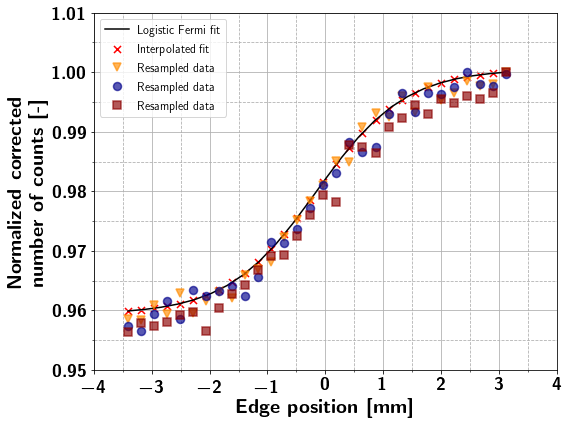

In [5]:
import matplotlib
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
# ----------------------------------------------------------------------------------------------------
# 	3. select +/- 1 FWHM of this fermi function and interpolate the fitted function
#	4. select 30 measurement points along that fitted function (use interpolation)
#	5. sample from poisson 1000 points for each of these positions
# ----------------------------------------------------------------------------------------------------

# +/-1 FWHM already taken in the last step

def interpolate_and_resample(df, Y_colname, num_measurements, tot_meas_time, num_samples, outputfolder, figname):
    case = df['case'].unique()[0]

    diameter = df['diameter'].unique()[0]

    fname = '{}ESF_fit_csv/case_{}_diameter_{}_mm_ESF_fit.csv'.format(master_folder,case,diameter)

    df_ESF = pd.read_csv(fname, index_col=0)

    X = df_ESF['x_pos_mm'].values
    Y = df_ESF['Y_log_fermi_func'].values
    Y_mcnp = df_ESF[Y_colname].values

    # interpolate
    interp_ESF = interp1d(X, Y, kind='cubic')  # angle is in radian
    qry_X = np.linspace(np.min(X), np.max(X), num=num_measurements, endpoint=True)
    qry_Y = interp_ESF(qry_X)

    # take measurement time into account
    # time per position
    time_per_pos = (tot_meas_time*60*60) / num_measurements  # convert from hour to second and then divide by number of measurements

    qry_Y = np.multiply(qry_Y, time_per_pos) 
    Y_mcnp = np.multiply(Y_mcnp, time_per_pos)
    Y = np.multiply(Y, time_per_pos)

    # PLOT
    # print('Plotting interpolated fit to ESF for case {}, diameter {} mm.'.format(case, diameter))
    # fig, ax = plt.subplots(1)	
    # ax.plot(X, Y, color='black', label='ESF fit')

    # ax.scatter(X, Y_mcnp, edgecolor='black', label='MCNP data', color='darkorange', s=70)
    # ax.scatter(qry_X, qry_Y, marker='x', edgecolor='red', label='Interpolated fit', color='red', s=25)

    # # FWHM, Y_log_fermi_func, p1, r_squared = compute_FWHM(X, df_poisson.iloc[:,ii].values,rad)

    # ax.tick_params('x', colors='black', labelsize=12)	
    # ax.tick_params('y', colors='black', labelsize=12)	
    # # grid
    # ax.grid(b=True, which='major', linestyle='-')#, color='gray')
    # ax.grid(b=True, which='minor', linestyle='--')#, color='gray')
    # plt.title('Case: {:.0f}, Diameter: {:.2f} mm, tot. meas time {:.0f} h'.format(case, diameter, time_per_pos))
    # plt.legend(loc='best')
    # plt.xlabel('Edge position [mm]')
    # plt.ylabel('Counts for tot. Neutron Yield: {:.1e} n/s'.format(S0))
    # plt.tight_layout()
    # plt.show()
    # # plt.savefig('./ESF_fit/interpolate_fitted_ESF_diameter_{:.2f}_mm_case_{:.0f}_ESF_fit.png'.format(diameter, case), dpi=300)
    # # plt.clf()
    # # plt.close('all')

    # add poisson noise to the fitted data(!). Noise is added to the FIT, not to the MCNP data
    this_df = pd.DataFrame()
    this_df['x_pos_mm'] = qry_X
    this_df['counts'] = qry_Y


    df_poisson = this_df['counts'].apply(lambda x: pd.Series(np.random.poisson(x, size=num_samples)))
    df_poisson['x_pos_mm'] = this_df['x_pos_mm']
    df_poisson['counts'] = this_df['counts']

    # PLOT
    print('Plotting interpolated fit and poisson noise to ESF for case {}, diameter {} mm.'.format(case, diameter))
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1)
    fs = 20
    markersize = 8
    plotY = Y/np.max(Y)
    ax.plot(X, plotY, color='black', label='Logistic Fermi fit')

    # ax.scatter(X, Y_mcnp, edgecolor='black', label='MCNP data', color='darkorange', s=70)
    plotqry_Y = qry_Y/np.max(qry_Y)
    ax.scatter(qry_X, plotqry_Y, marker='x', edgecolor='red', label='Interpolated fit', color='red', s=50)
    
    colors = ['darkorange', 'darkblue', 'darkred']
    markers = ['v','o','s']
    for ii,color,marker in zip(range(0, 3),colors, markers):
        Y = df_poisson.iloc[:,ii].values/np.max(df_poisson.iloc[:,ii].values)
        ax.plot(df_poisson['x_pos_mm'].values, Y, marker,color=color, markersize=markersize, label='Resampled data', alpha=0.65, markeredgewidth=1.5, markeredgecolor=color)

    plt.xlabel(r'\textbf{Edge position [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{Normalized corrected}' + '\n'+ r'\textbf{number of counts [-]}', fontsize=fs)

    # minor ticks x
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    # minor ticks y
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)

    ax.tick_params('x', colors='black', labelsize=fs-2)
    ax.tick_params('y', colors='black', labelsize=fs-2)

    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')
    plt.ylim(0.95,1.01)
    plt.xlim(-4,4)


    #     plt.yticks(np.arange(0.5,1.2,0.1))
    #     plt.xticks(np.arange(8,22,2))
    #     plt.xlim(7, 21)
    #     plt.ylim(0.5,1.1)
    my_handles, my_labels = ax.get_legend_handles_labels()
    my_handles = [my_handles[0], my_handles[4], my_handles[1], my_handles[2], my_handles[3]]
    my_labels = [my_labels[0], my_labels[4], my_labels[1], my_labels[2], my_labels[3]]
    
    leg1 = plt.legend(my_handles, my_labels, loc="best",  fontsize=12)
#     leg1.set_title(r"Data", prop = {'size': 12})

    plt.tight_layout()
    plt.savefig(f'{outputfolder}/{figname}.pdf')
    plt.show()
    


# import the fitted data
Y_colname = 'C_cutoff'
num_measurements = 30  # number of measurements (edge positions) for one experimental setup
tot_meas_time = 5  # total measurement time in hours
num_samples = 5  # number of poisson samples
data = df_MCNP_results[ (df_MCNP_results['diameter'] ==10) & (df_MCNP_results['case']==19) ]

outputfolder = '/Users/hkromer/polybox/Thesis/Chapters/DetailedNeutronGeneratorCharacterization/Figures/emitting_spot_size_noised_esf'
figname = 'emitting_spot_size_noised_esf'


interpolate_and_resample(data, Y_colname, num_measurements, tot_meas_time, num_samples, outputfolder, figname)

In [6]:
# ----------------------------------------------------------------------------------------------------
# 	3. select +/- 1 FWHM of this fermi function and interpolate the fitted function
#	4. select 30 measurement points along that fitted function (use interpolation)
#	5. sample from poisson 1000 points for each of these positions
# ----------------------------------------------------------------------------------------------------

# +/-1 FWHM already taken in the last step

def interpolate_and_resample(df, Y_colname, num_measurements, tot_meas_time, num_samples):
	case = df['case'].unique()[0]
	
	diameter = df['diameter'].unique()[0]

	fname = '{}ESF_fit_csv/case_{}_diameter_{}_mm_ESF_fit.csv'.format(master_folder,case,diameter)

	df_ESF = pd.read_csv(fname, index_col=0)

	X = df_ESF['x_pos_mm'].values
	Y = df_ESF['Y_log_fermi_func'].values
	Y_mcnp = df_ESF[Y_colname].values
	
	# interpolate
	interp_ESF = interp1d(X, Y, kind='cubic')  # angle is in radian
	qry_X = np.linspace(np.min(X), np.max(X), num=num_measurements, endpoint=True)
	qry_Y = interp_ESF(qry_X)

	# take measurement time into account
	# time per position
	time_per_pos = (tot_meas_time*60*60) / num_measurements  # convert from hour to second and then divide by number of measurements
	
	qry_Y = np.multiply(qry_Y, time_per_pos) 
	Y_mcnp = np.multiply(Y_mcnp, time_per_pos)
	Y = np.multiply(Y, time_per_pos)

	# PLOT
	# print('Plotting interpolated fit to ESF for case {}, diameter {} mm.'.format(case, diameter))
	# fig, ax = plt.subplots(1)	
	# ax.plot(X, Y, color='black', label='ESF fit')
	
	# ax.scatter(X, Y_mcnp, edgecolor='black', label='MCNP data', color='darkorange', s=70)
	# ax.scatter(qry_X, qry_Y, marker='x', edgecolor='red', label='Interpolated fit', color='red', s=25)
		
	# # FWHM, Y_log_fermi_func, p1, r_squared = compute_FWHM(X, df_poisson.iloc[:,ii].values,rad)
		
	# ax.tick_params('x', colors='black', labelsize=12)	
	# ax.tick_params('y', colors='black', labelsize=12)	
	# # grid
	# ax.grid(b=True, which='major', linestyle='-')#, color='gray')
	# ax.grid(b=True, which='minor', linestyle='--')#, color='gray')
	# plt.title('Case: {:.0f}, Diameter: {:.2f} mm, tot. meas time {:.0f} h'.format(case, diameter, time_per_pos))
	# plt.legend(loc='best')
	# plt.xlabel('Edge position [mm]')
	# plt.ylabel('Counts for tot. Neutron Yield: {:.1e} n/s'.format(S0))
	# plt.tight_layout()
	# plt.show()
	# # plt.savefig('./ESF_fit/interpolate_fitted_ESF_diameter_{:.2f}_mm_case_{:.0f}_ESF_fit.png'.format(diameter, case), dpi=300)
	# # plt.clf()
	# # plt.close('all')

	# add poisson noise to the fitted data(!). Noise is added to the FIT, not to the MCNP data
	this_df = pd.DataFrame()
	this_df['x_pos_mm'] = qry_X
	this_df['counts'] = qry_Y

	
	df_poisson = this_df['counts'].apply(lambda x: pd.Series(np.random.poisson(x, size=num_samples)))
	df_poisson['x_pos_mm'] = this_df['x_pos_mm']
	df_poisson['counts'] = this_df['counts']

	# PLOT
	print('Plotting interpolated fit and poisson noise to ESF for case {}, diameter {} mm.'.format(case, diameter))
	fig, ax = plt.subplots(1)	
	ax.plot(X, Y, color='black', label='ESF fit')
	
	# ax.scatter(X, Y_mcnp, edgecolor='black', label='MCNP data', color='darkorange', s=70)
	ax.scatter(qry_X, qry_Y, marker='x', edgecolor='red', label='Interpolated fit', color='red', s=25)
	for ii in range(0, 3):
		ax.scatter(df_poisson['x_pos_mm'].values, df_poisson.iloc[:,ii].values, marker='o', label='Poisson noise', s=25)
		
	# FWHM, Y_log_fermi_func, p1, r_squared = compute_FWHM(X, df_poisson.iloc[:,ii].values,rad)
		
	ax.tick_params('x', colors='black', labelsize=12)	
	ax.tick_params('y', colors='black', labelsize=12)	
	# grid
	ax.grid(b=True, which='major', linestyle='-')#, color='gray')
	ax.grid(b=True, which='minor', linestyle='--')#, color='gray')
	plt.title('Case: {:.0f}, Diameter: {:.2f} mm, time per pos {:.0f} s'.format(case, diameter, time_per_pos))
	plt.legend(loc='best')
	plt.xlabel('Edge position [mm]')
	plt.ylabel('Counts for tot. Neutron Yield: {:.1e} n/s'.format(S0))
	plt.tight_layout()
	# plt.show()
	plt.savefig('{}noised_ESF_fit_plots/noised_interpolatd_fitted_ESF_diameter_{:.2f}_mm_case_{:.0f}_ESF_fit.png'.format(master_folder, diameter, case), dpi=100)
	plt.clf()
	plt.close('all')

	fname = '{}noised_ESF_fit_csv/case_{}_diameter_{}_mm_tot_time_{}_hrs.csv'.format(master_folder,case,diameter, tot_meas_time)
	df_poisson.to_csv(fname)



# import the fitted data
Y_colname = 'C_cutoff'
num_measurements = 30  # number of measurements (edge positions) for one experimental setup
tot_meas_time = 5  # total measurement time in hours
num_samples = 1000  # number of poisson samples
df_MCNP_results.groupby(['case', 'diameter']).apply(lambda x: interpolate_and_resample(x, Y_colname, num_measurements, tot_meas_time, num_samples)).reset_index()


Plotting interpolated fit and poisson noise to ESF for case 1, diameter 1.0 mm.
Plotting interpolated fit and poisson noise to ESF for case 1, diameter 10.0 mm.
Plotting interpolated fit and poisson noise to ESF for case 2, diameter 1.0 mm.
Plotting interpolated fit and poisson noise to ESF for case 2, diameter 10.0 mm.
Plotting interpolated fit and poisson noise to ESF for case 3, diameter 1.0 mm.
Plotting interpolated fit and poisson noise to ESF for case 3, diameter 10.0 mm.
Plotting interpolated fit and poisson noise to ESF for case 4, diameter 1.0 mm.
Plotting interpolated fit and poisson noise to ESF for case 4, diameter 10.0 mm.
Plotting interpolated fit and poisson noise to ESF for case 5, diameter 1.0 mm.
Plotting interpolated fit and poisson noise to ESF for case 5, diameter 10.0 mm.
Plotting interpolated fit and poisson noise to ESF for case 6, diameter 1.0 mm.
Plotting interpolated fit and poisson noise to ESF for case 6, diameter 10.0 mm.
Plotting interpolated fit and pois

,index


In [7]:
# ----------------------------------------------------------------------------------------------------
#	6. analog to 2, re-compute logistic fermi function to ESF --> obtain 1000 FWHMs as p[2]*3.53 
# ----------------------------------------------------------------------------------------------------

def fit_FWHM_to_poisson(df, tot_meas_time):

	case = df['case'].unique()[0]
	diameter = df['diameter'].unique()[0]
	if case > -1:

	# if (case == 30) & (diameter > 12.0):
			# if case == 0:
		

		fname = '{}noised_ESF_fit_csv/case_{}_diameter_{}_mm_tot_time_{}_hrs.csv'.format(master_folder,case,diameter, tot_meas_time)
		
		df_ESF = pd.read_csv(fname, index_col=0)

		print('Processing FWHM of poisson noised fit case {}, diameter {} mm.'.format(case, diameter))

		X = df_ESF['x_pos_mm'].values
		Y = df_ESF['counts'].values

		# find the optimal p0 as initial guess for the fit, then use that to return the FWHM
		# m = np.mean(Y[0:5])
		# m = [1e6, 1e7, 1e8, 1e9, 1e10]
		m = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10, np.max(Y)]
		a = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]
		b = [1e-3, 1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 1e-3, 5e-3, 1e-4]
		c = [0.5, 2, 4, 6, 8, 10, 15, 20, 30]
		for kk in list(itertools.product(a,b,c,m)):
			
		# for kk in list(itertools.product(a,b,c)):
			p0 = [-kk[0], kk[1], kk[2]/3.53, kk[3]] # Initial guess for the parameters	
			FWHM_0, Y_log_fermi_func_0, p1_0, r_squared_0 = fun_calculate_FWHM_of_ESF(X, Y, p0)
			FWHM_0 = np.abs(FWHM_0)
			diff_fit =np.abs(Y_log_fermi_func_0[0]-Y_log_fermi_func_0[-1])
			diff_Y = np.abs(Y[0]-Y[-1])
			if (np.abs(FWHM_0) > 1e-1) & (np.abs(FWHM_0) < 2*diameter) & (np.divide(np.abs(diff_fit-diff_Y), diff_Y) < 0.5 ):  # computed FWHM larger than 0

				print(p1_0)
				break


		if FWHM_0 > 100:
			print('FWHM {} LARGER THAN 100! Exit.'.format(FWHM_0))
			sys.exit()
		print('FWHM_0: {} '.format(FWHM_0))
		print('p1_0: {}'.format(p1_0))
		
		# fit for the poisson noise
		cols = df_ESF.columns
		cols = [col for col in cols if re.search(r'\d', col)]

		df_ESF = df_ESF[cols]

		for ii in range(0,len(df_ESF.columns)):
			Y = df_ESF.iloc[:,ii].values
			FWHM, Y_log_fermi_func, p1, r_squared = fun_calculate_FWHM_of_ESF(X, Y, p1_0)
			FWHM = np.abs(FWHM)
			if ii == 0:
				s1 = pd.Series([FWHM], index=['FWHM_{:.0f}'.format(ii)])
			else:
				s1 = s1.append(pd.Series([FWHM], index=['FWHM_{:.0f}'.format(ii)]))

		s1 = s1.append(pd.Series([FWHM_0], index=['FWHM_orig']))
		# n, bins, patches = plt.hist(s1, 100, facecolor='g', alpha=0.75)
		# plt.plot([FWHM_0, FWHM_0], [0, np.max(n)], color='red')
		# plt.xlabel('FWHM')
		# plt.ylabel('Counted')
		# plt.grid(True)
		# # plt.show()
		# plt.savefig('./FWHM_on_poisson/noised_interpolated_fitted_ESF_diameter_{:.2f}_mm_case_{:.0f}_ESF_fit.png'.format(diameter, case), dpi=300)
		# plt.clf()
		# plt.close('all')
		

		# # a.set_index('idx', inplace=True)


		

		return s1


# # change only if needs recomputation for some reason
# # tot_meas_time = 3  # total measurement time in hours

df_poisson = df_MCNP_results.groupby(['case', 'diameter']).apply(lambda x: fit_FWHM_to_poisson(x, tot_meas_time)).reset_index()
fname = '{}FWHM_on_poisson_tot_time_{}_hrs.csv'.format(master_folder,tot_meas_time)
df_poisson.to_csv(fname)


Processing FWHM of poisson noised fit case 1, diameter 1.0 mm.
[-8.18365233e+03  8.57604395e-02 -1.59118483e-01  1.95555309e+05]
FWHM_0: 0.5616882441337896 
p1_0: [-8.18365233e+03  8.57604395e-02 -1.59118483e-01  1.95555309e+05]
Processing FWHM of poisson noised fit case 1, diameter 10.0 mm.
[-9.07978177e+03  7.38037133e-02 -1.01154071e+00  1.80778008e+05]
FWHM_0: 3.5707387152724563 
p1_0: [-9.07978177e+03  7.38037133e-02 -1.01154071e+00  1.80778008e+05]
Processing FWHM of poisson noised fit case 2, diameter 1.0 mm.
[-2.07677367e+04  2.48903361e-02 -1.75846251e-01  1.95686283e+05]
FWHM_0: 0.6207372667604779 
p1_0: [-2.07677367e+04  2.48903361e-02 -1.75846251e-01  1.95686283e+05]
Processing FWHM of poisson noised fit case 2, diameter 10.0 mm.
[-2.18087372e+04  1.14487624e-01 -1.07920046e+00  1.81458175e+05]
FWHM_0: 3.8095776403485253 
p1_0: [-2.18087372e+04  1.14487624e-01 -1.07920046e+00  1.81458175e+05]
Processing FWHM of poisson noised fit case 3, diameter 1.0 mm.
[-4.08310811e+04  1

<ipython-input-3-c2c29a9792b8>:15: RuntimeWarning: overflow encountered in exp
  z = np.exp( -( (x-p[1])/(p[2]) ) )


Processing FWHM of poisson noised fit case 7, diameter 10.0 mm.
[-1.44700045e+03  1.17812159e+00 -1.60116332e+00  2.70360925e+04]
FWHM_0: 5.652106521492791 
p1_0: [-1.44700045e+03  1.17812159e+00 -1.60116332e+00  2.70360925e+04]


/Users/hkromer/anaconda3/envs/py3.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:449: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


Processing FWHM of poisson noised fit case 8, diameter 1.0 mm.
[3.29889316e+03 4.46820042e-03 1.48174084e-01 2.57033263e+04]
FWHM_0: 0.5230545151750127 
p1_0: [3.29889316e+03 4.46820042e-03 1.48174084e-01 2.57033263e+04]
Processing FWHM of poisson noised fit case 8, diameter 10.0 mm.
[-3.43184220e+03  8.73611116e-01 -1.70929949e+00  2.72395981e+04]
FWHM_0: 6.033827184794999 
p1_0: [-3.43184220e+03  8.73611116e-01 -1.70929949e+00  2.72395981e+04]
Processing FWHM of poisson noised fit case 9, diameter 1.0 mm.
[ 6.42797251e+03 -2.37199949e-03  1.50665024e-01  2.26135444e+04]
FWHM_0: 0.5318475349797506 
p1_0: [ 6.42797251e+03 -2.37199949e-03  1.50665024e-01  2.26135444e+04]
Processing FWHM of poisson noised fit case 9, diameter 10.0 mm.
[6.68512579e+03 8.34112331e-02 1.65253996e+00 2.05975418e+04]
FWHM_0: 5.833466061803498 
p1_0: [6.68512579e+03 8.34112331e-02 1.65253996e+00 2.05975418e+04]
Processing FWHM of poisson noised fit case 10, diameter 1.0 mm.
[-8.44533211e+04  1.20749320e-02 -5.

## Compute mean and standard deviation for each case

In [8]:
noised = df_poisson.reset_index(drop=True)
print(noised.head())
print(noised.tail())

   case  diameter    FWHM_0    FWHM_1    FWHM_2    FWHM_3    FWHM_4    FWHM_5  \
0     1       1.0  0.458040  0.447419  0.699616  0.496521  0.574968  0.591190   
1     1      10.0  3.843707  3.630089  3.151778  3.158307  3.700380  4.026379   
2     2       1.0  0.603233  0.630372  0.582272  0.591302  0.612237  0.621263   
3     2      10.0  3.639337  3.753052  3.980158  3.925226  3.749501  3.874437   
4     3       1.0  0.611346  0.589640  0.626829  0.620706  0.608647  0.580871   

     FWHM_6    FWHM_7  ...  FWHM_991  FWHM_992  FWHM_993  FWHM_994  FWHM_995  \
0  0.509805  0.586428  ...  0.583054  0.527974  0.573244  0.592999  0.607188   
1  2.908482  4.198332  ...  3.676248  3.834269  3.478940  3.458025  3.972509   
2  0.571556  0.677203  ...  0.618640  0.622902  0.580836  0.601508  0.612526   
3  3.898368  3.467551  ...  3.921440  3.801976  3.547637  3.787196  3.768881   
4  0.611992  0.594147  ...  0.616813  0.592391  0.605273  0.602105  0.597828   

   FWHM_996  FWHM_997  FWHM_998 

In [9]:
# take only the FWHM columns
cols_fwhm = [c for c in noised.columns if "FWHM" in c]
# make a new df, with same index
df_fwhm = noised[cols_fwhm]
# compute mean and std
mean = df_fwhm.mean(axis = 1)
std = df_fwhm.std(axis = 1)
df_m_and_std = pd.DataFrame([mean, std], ['mean', 'std']).T
# join the two dataframes back
df_infos = noised[['case', 'diameter']]
df_fwhms = df_infos.join(df_m_and_std, on=df_infos.index)

# add properties to the df
df_props = pd.read_csv('/Users/hkromer/02_PhD/02_Data/09.NeutronEmittingSpot/01.FindingGoodParameters/df_properties_with_FWHM_penumbra.csv', index_col=0)
df_props['diameter'] = df_props['radius'] * 20 # convert to mm

df_out = pd.merge(df_fwhms, df_props,  how='left', left_on=['case','diameter'], right_on = ['case','diameter'])
df_out.drop(columns=['FWHM_LSF', 'FWHM_c'], inplace=True)
df_out.head()

,case,diameter,mean,std,D_W,D_det,W_det,dist_det,radius
0,1,1.0,0.564042,0.067572,0.10,0.5,0.2,30,0.05
1,1,10.0,3.611287,0.444339,0.10,0.5,0.2,30,0.50
2,2,1.0,0.622460,0.026563,0.25,0.5,0.2,30,0.05
3,2,10.0,3.809915,0.172227,0.25,0.5,0.2,30,0.50
4,3,1.0,0.607402,0.012368,0.50,0.5,0.2,30,0.05


## How much different is the FWHM for different detector depths

- tungsten depth is fixed to 0.5 cm
- 1 and 10 mm diameter source definition from MCNP6

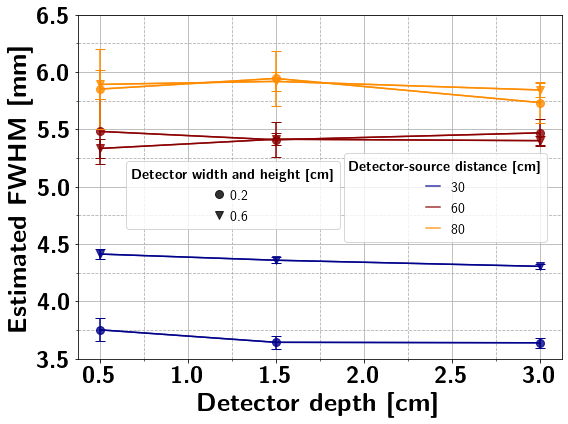

In [19]:
import matplotlib
import copy
# from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


diam = 10

# fix tungsten thickness to 0.5 cm
df = df_out[ (df_out['diameter'] == diam) & (df_out['D_W'] == 0.5)]

lst_D_det = df['D_det'].unique()
lst_D_W = df['D_W'].unique()
lst_W_det = df['W_det'].unique()
lst_dist_det = df['dist_det'].unique()



markers = ['o', 'v', '<', 's', 'D', '>'] 
colors = ['darkblue', 'darkred', 'darkorange', 'darkgreen']



# plot
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)
fs = 26
markersize = 8
outputfolder = '/Users/hkromer/polybox/Thesis/Chapters/DetailedNeutronGeneratorCharacterization/Figures/emitting_spot_size_finding_parameters/'
figname = f'fwhm_vs_detector_depth_{diam}'
handles = []  # legend handles to change color of legend

# markers are different detector width and heights
# colors are different detector distances
for W_det, marker in zip(lst_W_det, markers):
    for dist_det, color in zip(lst_dist_det, colors):
        this_data = df[ (df['W_det'] == W_det) & (df['dist_det'] == dist_det)]
        X = this_data['D_det'].values
        Y = this_data['mean'].values
        Y_err = this_data['std'].values
        ax1.errorbar(X, Y, yerr=Y_err, marker='.', color=color, capsize=5, markersize=0)   
        _, = ax1.plot(X, Y, marker=marker, markersize=markersize, label=dist_det, color=color, alpha=0.8)
        handles.append(copy.copy(_))

plt.ylabel(r'\textbf{Estimated FWHM [mm]}', fontsize=fs)
plt.xlabel(r'\textbf{Detector depth [cm]}', fontsize=fs)

# minor ticks x
minor_locator = AutoMinorLocator(2)
ax1.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)
ax1.tick_params('x', colors='black', labelsize=fs-2)
ax1.tick_params('y', colors='black', labelsize=fs-2)

ax1.grid(b=True, which='major', linestyle='-')
ax1.grid(b=True, which='minor', linestyle='--')



plt.yticks(np.arange(3.5,7.5,0.5))
plt.xticks(np.arange(0.5,3.5,0.5))
plt.xlim(0.375, 3.125)
plt.ylim(3.5,6.5)
# legend
# legend for the tungsten thickness
my_handles, my_labels = ax1.get_legend_handles_labels()
# my_handles = [my_handles[1], my_handles[0], my_handles[3], my_handles[2]]
# my_labels = [my_labels[1], my_labels[0], my_labels[3], my_labels[2]]
l1 = plt.legend(my_handles[:3], my_labels[:3], loc=(0.55, 0.34), markerscale=0, fontsize=14, handlelength=1)
l1.set_title(r"\textbf{Detector-source distance [cm]}", prop = {'size': 14})
# change color of legend
for h in handles:
    h.set_color("black")

l2 = plt.legend(handles[0::4], list(lst_W_det), loc=(0.10, 0.378), handlelength=0, fontsize=14)
l2.set_title(r"\textbf{Detector width and height [cm]}", prop = {'size': 14})
plt.gca().add_artist(l1)

plt.tight_layout()
plt.savefig(f'{outputfolder}/{figname}.pdf')
plt.show()

### 1 mm diameter

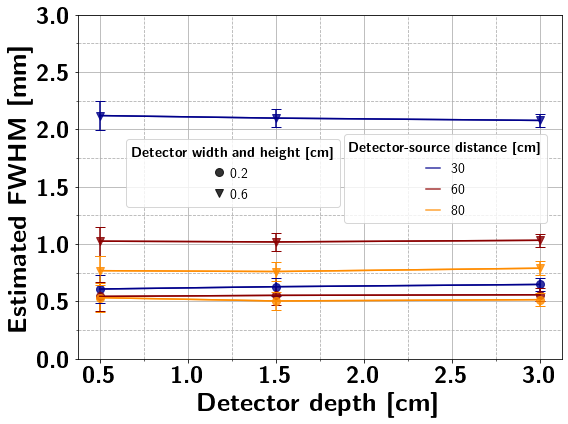

In [23]:
import matplotlib
import copy
# from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']



diam = 1

# fix tungsten thickness to 0.5 cm
df = df_out[ (df_out['diameter'] == diam) & (df_out['D_W'] == 0.5)]

lst_D_det = df['D_det'].unique()
lst_D_W = df['D_W'].unique()
lst_W_det = df['W_det'].unique()
lst_dist_det = df['dist_det'].unique()



markers = ['o', 'v', '<', 's', 'D', '>'] 
colors = ['darkblue', 'darkred', 'darkorange', 'darkgreen']



# plot
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)
fs = 26
markersize = 8
outputfolder = '/Users/hkromer/polybox/Thesis/Chapters/DetailedNeutronGeneratorCharacterization/Figures/emitting_spot_size_finding_parameters/'
figname = f'fwhm_vs_detector_depth_{diam}'
handles = []  # legend handles to change color of legend

# markers are different detector width and heights
# colors are different detector distances
for W_det, marker in zip(lst_W_det, markers):
    for dist_det, color in zip(lst_dist_det, colors):
        this_data = df[ (df['W_det'] == W_det) & (df['dist_det'] == dist_det)]
        X = this_data['D_det'].values
        Y = this_data['mean'].values
        _, = ax1.plot(X, Y, marker=marker, markersize=markersize, label=dist_det, color=color, alpha=0.8)
        ax1.errorbar(X, Y, yerr=Y_err, marker='.', color=color, capsize=5, markersize=0)   
        handles.append(copy.copy(_))

plt.ylabel(r'\textbf{Estimated FWHM [mm]}', fontsize=fs)
plt.xlabel(r'\textbf{Detector depth [cm]}', fontsize=fs)


# minor ticks x
minor_locator = AutoMinorLocator(2)
ax1.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)
ax1.tick_params('x', colors='black', labelsize=fs-2)
ax1.tick_params('y', colors='black', labelsize=fs-2)


ax1.tick_params('x', colors='black', labelsize=fs-2)
ax1.tick_params('y', colors='black', labelsize=fs-2)

ax1.grid(b=True, which='major', linestyle='-')
ax1.grid(b=True, which='minor', linestyle='--')



plt.yticks(np.arange(0,3.5,0.5))
plt.xticks(np.arange(0.5,3.5,0.5))
plt.xlim(0.375, 3.125)
plt.ylim(0,3)
# legend
# legend for the tungsten thickness
my_handles, my_labels = ax1.get_legend_handles_labels()
# my_handles = [my_handles[1], my_handles[0], my_handles[3], my_handles[2]]
# my_labels = [my_labels[1], my_labels[0], my_labels[3], my_labels[2]]
l1 = plt.legend(my_handles[:3], my_labels[:3], loc=(0.55, 0.395), markerscale=0, fontsize=14, handlelength=1)
l1.set_title(r"\textbf{Detector-source distance [cm]}", prop = {'size': 14})
# change color of legend
for h in handles:
    h.set_color("black")

l2 = plt.legend(handles[0::4], list(lst_W_det), loc=(0.10, 0.442), handlelength=0, fontsize=14)
l2.set_title(r"\textbf{Detector width and height [cm]}", prop = {'size': 14})
plt.gca().add_artist(l1)

plt.tight_layout()
plt.savefig(f'{outputfolder}/{figname}.pdf')
plt.show()

- Error are given by the standard deviation of the 1000 fitted ESFs (assuming a poisson distribution)
- The results conclude that there is negligible influence of the depth of the detector on the ESF seen by the detector
- However, a deeper detector means that there will